# Домашняя работа 9. Деревья решений. (32 балла)

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

## Полезная литература

- [Habrahabr: ODS деревья решений](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy)
- [ВМК МГУ семинары по решающим деревьям](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem04_trees.pdf)
- [Sklearn Decision Trees](http://scikit-learn.org/stable/modules/tree.html)

## 1. Сравнение моделей деревьев

В этом блоке вы сравните разные конфигурации композиций деревьев:
- DecisionTree
- Bagging
- Bagging с другими настройками подбора признаков для разбиения
- RandomForest

Будем использовать [датасет с винишком](https://archive.ics.uci.edu/ml/datasets/wine+quality) - это задача то ли классификации то ли регресси - нужно предсказывать качество вина. Будем думать что это классификация.

![](https://upload.wikimedia.org/wikipedia/en/thumb/7/7c/Lulz_Security.svg/300px-Lulz_Security.svg.png)

### 1.1 Чтение данных (1 балла)

Данные лежат как обычно в `'../../data/winequality-red.csv.gz'`.

- Прочитайте их с помощью pandas
- нарисуйте countplot целевого признака `quality`.
- Что вы думаете по поводу количества представителей каждого класса.
- Разбейте данные на X и y.

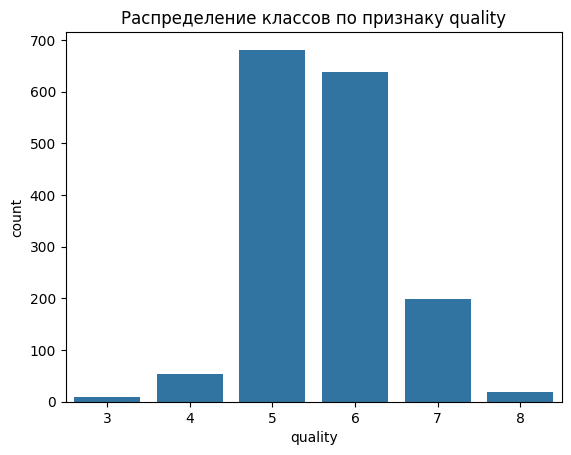

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('../data/winequality-red.csv.gz', sep=';')

sns.countplot(x='quality', data=data)
plt.title('Распределение классов по признаку quality')
plt.show()

In [20]:
X = data.drop(columns=['quality'])
y = data['quality']

print("Количество представителей каждого класса:")
print(data['quality'].value_counts().sort_index())

Количество представителей каждого класса:
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64


### 1.2 Сравнение моделей (4 балла)

Задача классификации. Все признаки уже числовые. Значит можно пробовать просто все модели и выбрать лучшую. Так и поступим, сделайте кросс валидацию на 5 фолдах, используя `sklearn.model_selection.KFold` как аргумент у `cross_val_score`. Метрика качества будет `accuracy`.

Алгоритмы для тестирования:
- KNeighborsClassifier с 10 соседями
- KNeighborsClassifier с 10 соседями и масштабированием StandartScaler
- RidgeClassifier
- DecisionTreeClassifier 
- BaggingClassifier c 100 деревьев
- BaggingClassifier с 100 деревьев и каждое дерево обучается только по половине случайно выбранных признаков (см аргументы)
- RandomForestClassifier c 100 деревьев

Выведите среднее значение метрики качества для каждого из классификаторов. 

**hint**: каждый следующий алгоритм, будет показывать качество лучше, чем предыдущий. Если у вас не так - то что-то вы делаете неправильно. Везде зафиксируйте random_state=42.

In [21]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = []

In [22]:
knn = KNeighborsClassifier(n_neighbors=10)
models.append(("KNN", knn))

In [23]:
knn_scaled = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=10))
])
models.append(("KNN_Scaled", knn_scaled))

In [24]:
ridge = RidgeClassifier(random_state=42)
models.append(("Ridge", ridge))

In [25]:
dt = DecisionTreeClassifier(random_state=42)
models.append(("DecisionTree", dt))

In [26]:
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    random_state=42
)
models.append(("Bagging", bagging))

In [27]:
bagging_half_features = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    max_features=0.5,
    random_state=42
)
models.append(("Bagging_Half_Features", bagging_half_features))

In [28]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
models.append(("RandomForest", rf))

In [29]:
results = {}
for name, model in models:
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    results[name] = scores.mean()

for name, mean_score in results.items():
    print(f"{name}: {mean_score:.4f}")

KNN: 0.5122
KNN_Scaled: 0.5816
Ridge: 0.5835
DecisionTree: 0.6179
Bagging: 0.6980
Bagging_Half_Features: 0.6948
RandomForest: 0.7017


### 1.3 Расуждения (8 баллов)

Ответьте на вопросы развернуто, можете полистать литературу:

- почему наблюдается значимая разница в качестве у KNeighborsClassifier с масштабированием и без
- почему масштабирование не важно для деревьев решений
- почему бэггинг на половине признаков для каждого дерева дал качество предсказания больше, чем на всех? (а он дал!)
- у какой модели наибольшей отклонение от среднего качества предсказаний? А почему??

- Масштабирование важно для kNN, так как этот алгоритм основан на расстояниях между объектами. Без масштабирования признаки с большими значениями начинают доминировать над остальными, искажая расстояния. После масштабирования все признаки становятся равнозначными, что позволяет алгоритму работать более корректно.

- Деревья решений не зависят от масштаба признаков, так как они работают через сравнение значений внутри одного признака (например, "значение больше или меньше определенной точки"). Таким образом, абсолютные величины не влияют на процесс построения дерева.

- Использование половины признаков для каждого дерева снижает корреляцию между деревьями в ансамбле, что делает модель более устойчивой к переобучению. Благодаря этому общее качество предсказания может提高аться, даже если каждое отдельное дерево становится менее точным.

- DecisionTree имеет наибольшее отклонение, так как склонен к переобучению и чрезмерно зависит от конкретного разбиения данных. В разных фолдах кросс-валидации дерево может строиться по-разному, что приводит к большим колебаниям в качестве предсказаний. Ансамблевые методы (Bagging, RandomForest) более стабильны, так как они усредняют результаты нескольких моделей.

## 2 Переобучение и Ко

В последнем задании вы уже заметили, что случайный лес может вести себя немного нестабильно. В этом задании мы возьмем опять датасет MNIST(простите) и будем его решать деревьями. Почему мы взяли его? Потому что в нем фактически много разных признаков (значения пикселей в пространстве), а деревья строятся делая разбиения по признакам. Обычно на эти разбиения не обращают внимание, так как главное что тюнят - это глубина дереьвев, количество деревьев, а кучу других параметров обходят стороной, так как они "неясные". Попробуем прояснить их.

### 2.1 Загрузка датасета (1 балл)

Загрузите датасет с помощью функции `sklearn.datasets.load_digits`. В нем будут 64px картинки в векторной форме.

Нарисуйте первые 10 цифр в одной ячейке, чтобы было красиво.

In [31]:
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

In [32]:
print(f"Количество образцов: {len(digits.data)}")
print(f"Размер изображений: {int(np.sqrt(digits.data.shape[1]))}x{int(np.sqrt(digits.data.shape[1]))} пикселей")

Количество образцов: 1797
Размер изображений: 8x8 пикселей


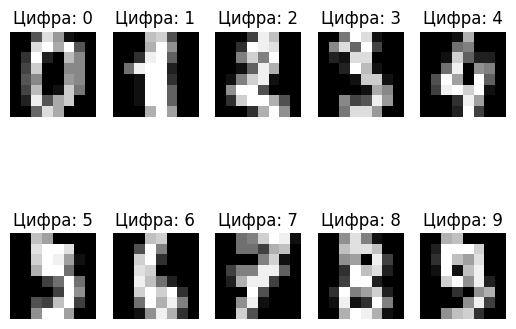

In [34]:
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(digits.images[i], cmap='gray')
    plt.title(f"Цифра: {digits.target[i]}")
    plt.axis('off')
plt.show()

### 2.2 Перебор классификаторов (3 балла)

В этом задании вам снова придется перебрать несколько классификаторов, но теперь мы обратим внимание на другие гиперпараметры и их влияние на качество классификации, кстати опять `accuracy`.

Сделайте кроссвалидацию на 10 фолдах, указав `cv=10` для следующих классификаторов:

- DecisionTreeClassifier с параметрами по-умолчанию
- BaggingClassifier с 100 деревьвев
- BaggingClassifier с 100 деревьев, НО с ограничением на максимальное количество признаков, участвующих при обучении каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков.
- BaggingClassifier с 100 деревьев, НО с ограничением на количество признаков участвующих в разбиении для каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков. Это отличается от предыдущей модели тем, где ограничивается `max_features`. Читайте документацию :trollface:
- обычный случайный лес со 100 деревьями

In [35]:
X, y = load_digits(return_X_y=True)

N_features = X.shape[1]

sqrt_N = int(np.sqrt(N_features))

models = []

In [37]:
models.append(("DecisionTree", DecisionTreeClassifier(random_state=42)))

models.append(("Bagging", BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    random_state=42
)))

models.append(("Bagging_max_features", BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    max_features=sqrt_N,
    random_state=42
)))

models.append(("Bagging_split_features", BaggingClassifier(
    estimator=DecisionTreeClassifier(max_features=sqrt_N, random_state=42),
    n_estimators=100,
    random_state=42
)))

models.append(("RandomForest", RandomForestClassifier(
    n_estimators=100,
    random_state=42
)))

In [38]:
results = {}
for name, model in models:
    scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    results[name] = scores.mean()

results

{'DecisionTree': np.float64(0.8335909373060211),
 'Bagging': np.float64(0.9270732464307884),
 'Bagging_max_features': np.float64(0.9298851644941031),
 'Bagging_split_features': np.float64(0.9549224084419615),
 'RandomForest': np.float64(0.9493544382371197)}

In [40]:
for name, mean_score in results.items():
    print(f"{name}: {mean_score:.4f}")

DecisionTree: 0.8336
Bagging: 0.9271
Bagging_max_features: 0.9299
Bagging_split_features: 0.9549
RandomForest: 0.9494


### 2.3 В чём разница? (3 балла)

Ответье на вопрос: 

Странно то как? Почему ограничение на количество признаков в разбиении дерева и ограничение в количестве признаков для построения каждого дерева в BaggingClasifier дало СОВСЕМ разный результат в качестве предсказания? В чем магия?

![](https://i.ytimg.com/vi/_5GWMIAHc08/hqdefault.jpg)

Разница в том, как применяется ограничение признаков. Когда мы ограничиваем количество признаков для разбиений в дереве, каждое разбиение выполняется на меньшем наборе случайных признаков, что снижает корреляцию между деревьями и помогает лучше обобщать. Но когда мы ограничиваем количество признаков для всего дерева в Bagging, некоторые важные признаки могут вообще не попасть в дерево, из-за чего качество падает. Случайный лес умнее в выборе признаков на каждом шаге, а не для всего дерева сразу

### 2.4 Количество деревьев (2 балла)

Сделайте перебор количества деревьев для `RandomForestClassifier`. Сохраните качества кросс валидации на 10 фолдах для `[1,5,10,15,50,100,150,200,300]` количества деревьев. Нарисуйте график, где по оси x - количество деревьев, а по оси y - качество. При каком количестве деревьев получается самое хорошее качество?

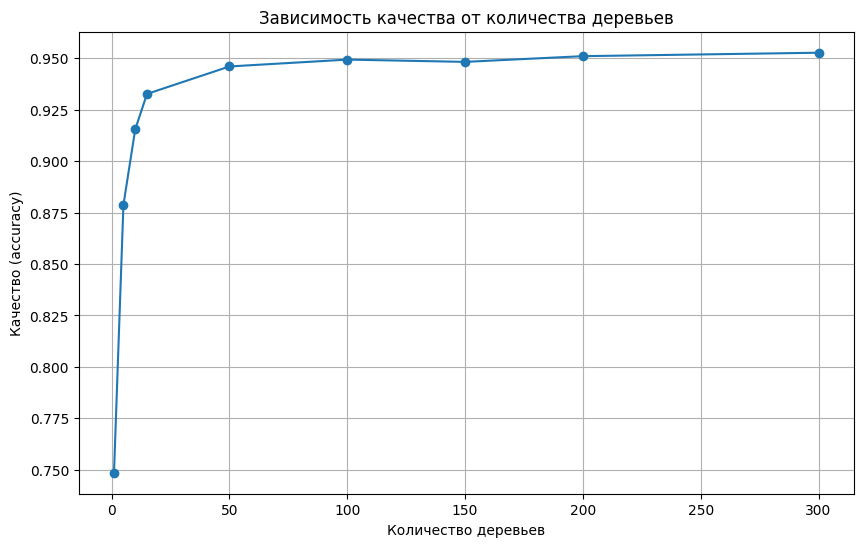

In [41]:
n_estimators_list = [1, 5, 10, 15, 50, 100, 150, 200, 300]
cv_scores = []

for n_estimators in n_estimators_list:
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, cv_scores, marker='o')
plt.xlabel('Количество деревьев')
plt.ylabel('Качество (accuracy)')
plt.title('Зависимость качества от количества деревьев')
plt.grid(True)
plt.show()

In [42]:
best_n_estimators = n_estimators_list[np.argmax(cv_scores)]
print(f"Лучшее количество деревьев: {best_n_estimators} с качеством {max(cv_scores):.4f}")

Лучшее количество деревьев: 300 с качеством 0.9527


### 2.5 Количество признаков  (2 балла)

Переберите теперь максимальное количество признаков для `RandomForestClassifier` на 100 деревьях, от 1 до 64 с шагом 5. Постройте график качества по кроссвалидации на 10 фолдах.

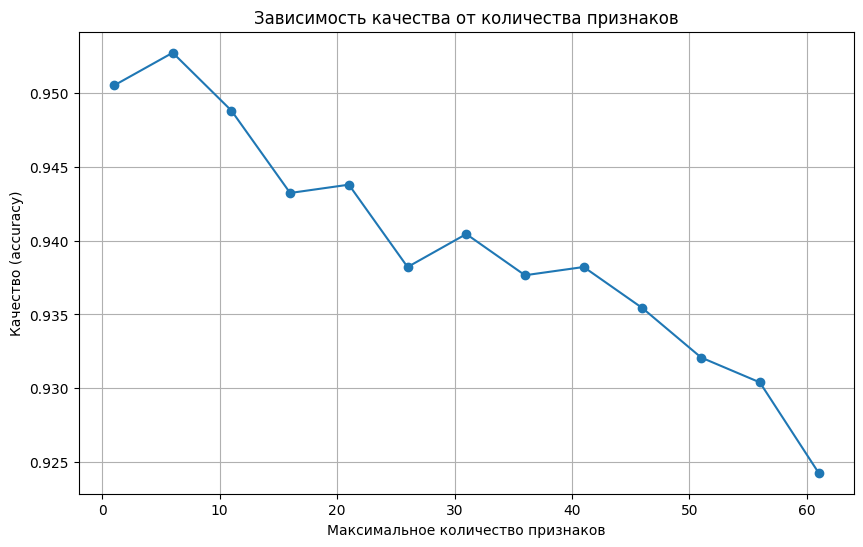

In [43]:
max_features_list = range(1, 65, 5)
cv_scores_features = []

for max_features in max_features_list:
    model = RandomForestClassifier(n_estimators=100, max_features=max_features, random_state=42)
    scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    cv_scores_features.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(max_features_list, cv_scores_features, marker='o')
plt.xlabel('Максимальное количество признаков')
plt.ylabel('Качество (accuracy)')
plt.title('Зависимость качества от количества признаков')
plt.grid(True)
plt.show()

In [44]:
best_max_features = max_features_list[np.argmax(cv_scores_features)]
print(f"Лучшее количество признаков: {best_max_features} с качеством {max(cv_scores_features):.4f}")

Лучшее количество признаков: 6 с качеством 0.9527


### 2.5 Вопросы по RandomForest (8 баллов)

Ответьте на вопросы:

- Что происходит с ростом числа деревьев у случайного леса. Можно ли просто всегда брать 5000 деревьев и быть счастливым?
- Как зависит качество предсказания в дереве в зависимости от max_features?
- Почему качество зависит от max_features?
- Как глубина деревьев влияет на качество случайного леса?

- С ростом числа деревьев качество обычно улучшается, но до определенного предела, после которого оно стабилизируется. Брать 5000 деревьев всегда неэффективно - это увеличивает время обучения без значительного прироста качества.

- Качество сначала растет с увеличением max_features, достигает пика и затем может снижаться. Оптимальное значение зависит от данных

- max_features управляет диверсификацией деревьев. Маленькое значение делает деревья слишком разными (переобучение), а большое - слишком похожими (недообучение). Оптимум находится где-то между

- Маленькая глубина ограничивает сложность модели, что может привести к недообучению. Большая глубина увеличивает риск переобучения. Случайный лес лучше справляется с глубокими деревьями благодаря ансамблевому подходу, но оптимальная глубина все равно требуется для баланса между качеством и обобщающей способностью.

![](https://habrastorage.org/web/ad8/366/a44/ad8366a4469346c6b2e1306495b05d1a.jpg)